# [WUM] PD3 - Mateusz Polakowski

Praca domowa polegała na wzięciu udziału w konkursie dotyczącym predykcji etykiety rodzaju zakupów klientów sieci *Walmart*. Szczegóły znajdują się [pod tym linkiem](https://www.kaggle.com/c/walmart-recruiting-trip-type-classification). Co prawda, konkurs zakończył się dawno temu, jednak dane są nadal dostępne, a problem inżynierii cech, który jest głównym tematem tej pracy, wziąż aktualny. <br/> 

W poniższym raporcie zobaczymy jak dobrą celność można uzyskać dzięki inżynierii cech wejściowego zbioru.

## Załadowanie potrzebnych pakietów

In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import category_encoders as ce
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")
pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

## Wczytanie danych

In [2]:
df = pd.read_csv("./../../../../Datasets/PD3 - Walmart Trip Type/train.csv")

In [3]:
df.head()

,TripType,VisitNumber,Weekday,Upc,ScanCount,DepartmentDescription,FinelineNumber
0,999,5,Friday,6.811315e+10,-1,FINANCIAL SERVICES,1000.0
1,30,7,Friday,6.053882e+10,1,SHOES,8931.0
2,30,7,Friday,7.410811e+09,1,PERSONAL CARE,4504.0
3,26,8,Friday,2.238404e+09,2,PAINT AND ACCESSORIES,3565.0
4,26,8,Friday,2.006614e+09,2,PAINT AND ACCESSORIES,1017.0


Opisy zmiennych skopiowane ze strony konkursu:
* **TripType** - a categorical id representing the type of shopping trip the customer made. <br/> This is the ground truth that you are predicting. TripType_999 is an "other" category.
* **VisitNumber** - an id corresponding to a single trip by a single customer
* **Weekday** - the weekday of the trip
* **UPC** - the *UPC* number of the product purchased
* **ScanCount** - the number of the given item that was purchased. A negative value indicates a product return.
* **DepartmentDescription** - a high-level description of the item's department
* **FinelineNumber** - a more refined category for each of the products, created by Walmart

## Analiza zbioru danych
Zauważmy najpierw, że w tabeli są wiersze z brakującymi danymi. Przede wszystkim brakuje w tych rekordach informacji o numerze *UPC* produktów, czy podstawowej lub szczegółowej informacji na temat działu z którego dany produkt pochodzi. <br/>
Nie jest to ogromny cios, ponieważ raczej skupić należy się gdzie indziej, niż na dokładnych numerach *UPC*. Mimo tego:

In [4]:
print("Odsetek rekordów posiadających brakujące dane:",
      np.round(100 * len(df[df.isnull().any(axis=1)]) / len(df), 3))

Odsetek rekordów posiadających brakujące dane: 0.638


Zatem możemy sobie pozwolić na wyrzucenie nastręczających problemy rekordów:

In [5]:
df.dropna(inplace = True)
print("Odsetek rekordów posiadających brakujące dane:",
      np.round(100 * len(df[df.isnull().any(axis=1)]) / len(df), 3))

Odsetek rekordów posiadających brakujące dane: 0.0


## Inżynieria cech

Niestety, ale liczba posiadanych cech nie jest wystarczająca, aby wyszkolić dobry model. Przejdźmy zatem do obróbki danych.

Przede wszystkim dodajmy trzy nowe kolumny:
* **UniqueProductsPerTrip** - liczba unikalnych przedmiotów kupionych / zwróconych,
* **TotalProductsPerTrip** - liczba wszystkich przedmiotów kupionych / zwróconych,
* **RateProductPerTrip** - stosunek dwóch powyższych.

In [6]:
df_temp = df.copy()
df_temp.ScanCount = abs(df_temp.ScanCount)
prod_summary = pd.concat([df_temp.groupby("VisitNumber").size().reset_index().iloc[:, 1],
                         df_temp.groupby("VisitNumber").ScanCount.sum().reset_index().iloc[:, 1]],
                         axis=1)

unique_prod, total_prod, rate_prod = [], [], []
for _, row in prod_summary.iterrows():
    row = list(row)
    unique_prod.extend([row[0]] * row[0])
    total_prod.extend([row[1]] * row[0])
    rate_prod.extend([np.round(row[0] / row[1], 2)] * row[0])
df["UniqueProductsPerTrip"] = unique_prod
df["TotalProductPerTrip"] = total_prod
df["RateProductPerTrip"] = rate_prod

Skoro już zaczęliśmy wyciągać unikalne wartości z tabeli na podstawie cechy *VisitNumber*, to wyodrębnijmy również liczbę działów odwiedzonych podczas każdej wizyty w sklepie (nowa kolumna **UniqueDepartmentsPerTrip**):

In [7]:
unique_dep = df.groupby(["VisitNumber", "DepartmentDescription"]).size().reset_index() \
                .groupby("VisitNumber").size().reset_index()
unique_dep_per_trip = []
for _, row in pd.concat([df.groupby("VisitNumber").size().reset_index().iloc[:, 1],
                         unique_dep.iloc[:, 1]], 
                        axis=1).iterrows():
    row = list(row)
    unique_dep_per_trip.extend([row[1]] * row[0])
df["UniqueDepartmentsPerTrip"] = unique_dep_per_trip

Patrząc na unikalne wartości kolumny *DepartmentDescription* można natrafić się na łudząco podobne dwie kategorie: *MENSWEAR* oraz *MENS WEAR* - połączmy je:

In [8]:
df.DepartmentDescription = df.DepartmentDescription.apply(lambda x: "MENSWEAR" 
                                                          if x.startswith("MENS") else x)

---
Teraz zajmijmy się głównym aspektem naszego zbioru danych. Istotny jest fakt, że wartość *TripType*, którą chcemy przewidywać, nie jest niczym losowym - jest to całkiem różniąca zbiór danych kategoria. Przykładowo, na grafice poniżej widać jakie działy odwiedzali klienci, których *TripType* był równy 19 - głównie *Electronics*. Analogiczne stwierdzenia można uzyskać zmieniając wartość filtrującą:

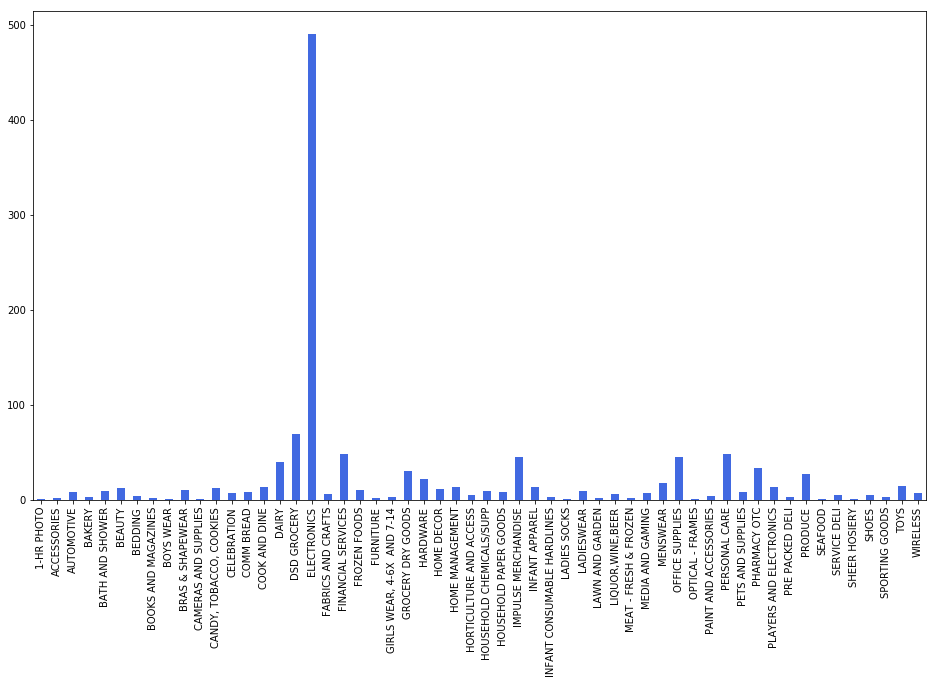

In [9]:
plt.figure(figsize=(16,9))
df.loc[df.TripType==19,:].groupby('DepartmentDescription').size().plot(kind='bar', color='royalblue')
plt.xlabel("")
plt.show()

Utwórzmy zatem informacje w każdym rekordzie zbioru, która mówi, czy dokonany zakup był w najbardziej popularnym dziale danego *TripType* (nowa kolumna **WasMostPopDeptVis**):

In [10]:
temp = df.groupby(["TripType", "DepartmentDescription"]).size().reset_index()
temp.columns = list(temp.columns[:2]) + ["Count"]
temp = pd.merge(temp.groupby("TripType").Count.max().reset_index(), 
                temp, 
                how='left', on=['TripType', 'Count']).iloc[:, [0, 2]]
df = pd.merge(df, temp, how='left', on='TripType')
df["WasMostPopDeptVis"] = pd.Series(df.DepartmentDescription_x == df.DepartmentDescription_y, dtype='int32')

Ostatnie przymiarki zbioru danych przed kodowaniem pozostałych zmiennych kategorycznych:

In [11]:
df['Target'] = df.TripType
df = df.drop(["VisitNumber", "Upc", 
                "DepartmentDescription_x", "DepartmentDescription_y",
                "FinelineNumber", "ScanCount"], axis=1)

Powyższa inżynieria cech namieszała sporo w wejściowym zbiorze danych. Zanim przejdziemy do kodowania zmiennych, spójrzmy jak wygląda on teraz:

In [12]:
df.head()

,TripType,Weekday,UniqueProductsPerTrip,TotalProductPerTrip,RateProductPerTrip,UniqueDepartmentsPerTrip,WasMostPopDeptVis,Target
0,999,Friday,1,1,1.00,1,1,999
1,30,Friday,2,2,1.00,2,1,30
2,30,Friday,2,2,1.00,2,0,30
3,26,Friday,22,31,0.71,6,0,26
4,26,Friday,22,31,0.71,6,0,26


In [13]:
ce_one_hot = ce.OneHotEncoder(cols=['Weekday'])
df = ce_one_hot.fit_transform(df).drop("Weekday_-1", axis=1)

ce_target = ce.TargetEncoder(cols=["TripType"])
df = ce_target.fit_transform(df, df.WasMostPopDeptVis)

Poniżej jeszcze zobaczmy na wygląd zbioru danych po kodowaniu zmiennych, których jest o wiele więcej:

In [14]:
df.head()

,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6,Weekday_7,TripType,UniqueProductsPerTrip,TotalProductPerTrip,RateProductPerTrip,UniqueDepartmentsPerTrip,WasMostPopDeptVis,Target
0,1,0,0,0,0,0,0,0.132788,1,1,1.00,1,1,999
1,1,0,0,0,0,0,0,0.235246,2,2,1.00,2,1,30
2,1,0,0,0,0,0,0,0.235246,2,2,1.00,2,0,30
3,1,0,0,0,0,0,0,0.302837,22,31,0.71,6,0,26
4,1,0,0,0,0,0,0,0.302837,22,31,0.71,6,0,26


Finalnie, przejdźmy do predykcji. Można zauważyć, że wszystkie powyższe manewry doprowadziły nas do satysfakcjonujących wyników celności przewidywań modelu oraz niskich wyników funkcji *log_loss*, którą użytkownicy serwisu *Kaggle* byli w konkursie oceniani:

In [15]:
X_proc, y_proc = df.drop("Target", axis=1).reset_index(drop=True), df.Target.reset_index(drop=True)
X_proc, y_proc = X_proc.loc[np.logical_not(X_proc.duplicated())], y_proc[np.logical_not(X_proc.duplicated())]

In [16]:
model = RandomForestClassifier(random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_proc, y_proc, 
                                                    test_size=0.2, 
                                                    random_state=1234)
X_train, X_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True)
y_train, y_test = y_train.reset_index(drop=True), y_test.reset_index(drop=True)

model.fit(X_train, y_train)
print("Celność modelu:", accuracy_score(y_test, model.predict(X_test)))
print("Log_loss modelu:", log_loss(y_test, model.predict_proba(X_test)))

Celność modelu: 0.8153711108943724
Log_loss modelu: 0.9777822357458902
